# Projet 8 : Déployez un modèle dans le cloud

## 1- Import des librairies

Les packages nécessaires ont été installé via l'étape de **bootstrap** à l'instanciation du serveur.

In [1]:
import pandas as pd
import numpy as np
import io
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf
from pyspark.ml.functions import vector_to_array
from pyspark.ml.linalg import Vectors, VectorUDT

# Preprocessing
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1679400906818_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2- Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [2]:
# On spécifie le chemin du bucket
PATH = 's3://salma-p8-data'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://salma-p8-data
PATH_Data:   s3://salma-p8-data/Test
PATH_Result: s3://salma-p8-data/Results

## 3- Traitement des données

In [3]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://salma-p8-dat...|2023-03-07 17:10:04|  4815|[FF D8 FF E0 00 1...|
|s3://salma-p8-dat...|2023-03-07 17:10:04|  4790|[FF D8 FF E0 00 1...|
|s3://salma-p8-dat...|2023-03-07 17:10:05|  4769|[FF D8 FF E0 00 1...|
|s3://salma-p8-dat...|2023-03-07 17:10:04|  4760|[FF D8 FF E0 00 1...|
|s3://salma-p8-dat...|2023-03-07 17:10:04|  4752|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>On ne conserve que le **path** de l'image et on ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [5]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------+--------------+
|path                                            |label         |
+------------------------------------------------+--------------+
|s3://salma-p8-data/Test/Apple Braeburn/3_100.jpg|Apple Braeburn|
|s3://salma-p8-data/Test/Apple Braeburn/4_100.jpg|Apple Braeburn|
|s3://salma-p8-data/Test/Apple Braeburn/7_100.jpg|Apple Braeburn|
|s3://salma-p8-data/Test/Apple Braeburn/6_100.jpg|Apple Braeburn|
|s3://salma-p8-data/Test/Apple Braeburn/5_100.jpg|Apple Braeburn|
+------------------------------------------------+--------------+
only showing top 5 rows

None

## 4- Modèle

### 4.1 Préparation du modèle

On choisit le modèle MobileNetV2

In [6]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14536120/14536120 [==============================] - 1s 0us/step

On va ensuite enlever les deux dernières couches du modèle pour récupérer les features

In [7]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# traitement de diffusion des poids du modèle Tensorflow sur les clusters
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [10]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4.2 Définition du processus de chargement des images <br/> et application de leur featurisation à travers l'utilisation de pandas UDF

In [11]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1679400906818_0003/container_1679400906818_0003_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:398: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

### 4.3 Exécutions des actions d'extractions de features

In [12]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://salma-p8-data/Results

### 4.4 ACP avec spark

In [14]:
features_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

#### (a) On convertit la col float en vecteur

In [15]:
# Création d'une fonction UDF pour convertir "array<float>" en "vector"
to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())

# Appliquer la fonction UDF à la colonne "features"
df_test = features_df.withColumn("features_vector", to_vector_udf("features"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
df_test.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vector: vector (nullable = true)

#### (b) Standardisation

In [17]:
# on standardise nos données avec la méthode fit et après la suite on va les transformer avec transform
t0scaler_fit = time.time()
scaler = StandardScaler(
    inputCol = 'features_vector', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(df_test)
tfscaler_fit = time.time()
print("Temps d'exécution du scaler avec fit : {:.4f} seconds".format(tfscaler_fit - t0scaler_fit))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Temps d'ex?cution du scaler avec fit : 35.6372 seconds

In [18]:
t0scaler_transform = time.time()
df_scaled = scaler.transform(df_test)
tfscaler_transform = time.time()
print("Temps d'exécution du scaler avec transform : {:.4f} seconds".format(tfscaler_transform - t0scaler_transform))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Temps d'ex?cution du scaler avec transform : 0.2248 seconds

#### (c) Application de l'ACP et choix du nombre de composantes

In [19]:
# On va définir le nombre de composantes à choisir
t0_kpca = time.time()
pca = PCA(k=8, inputCol="scaledFeatures", outputCol="pcaFeatures") 
pcaModel = pca.fit(df_scaled) # fit pca
print(pcaModel.explainedVariance) # explication de la variance
cumValues = pcaModel.explainedVariance.cumsum() # get the cumulative values
tf_kpca= time.time()
print("Temps d'exécution de l'ACP pour le choix du k : {:.4f} seconds".format(tf_kpca - t0_kpca))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.3744800010258331,0.20119964964566478,0.0653145428803091,0.058030876866289605,0.04574249179109949,0.03198401091470984,0.02976399786559234,0.02145371441558065]
Temps d'ex?cution de l'ACP pour le choix du k : 70.1316 seconds

In [20]:
# Graphiquement
plt.figure(figsize=(10,8))
plt.plot(range(1,9), cumValues, marker = 'o', linestyle='--')
plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0, 0.5, 'cumulative explained variance')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

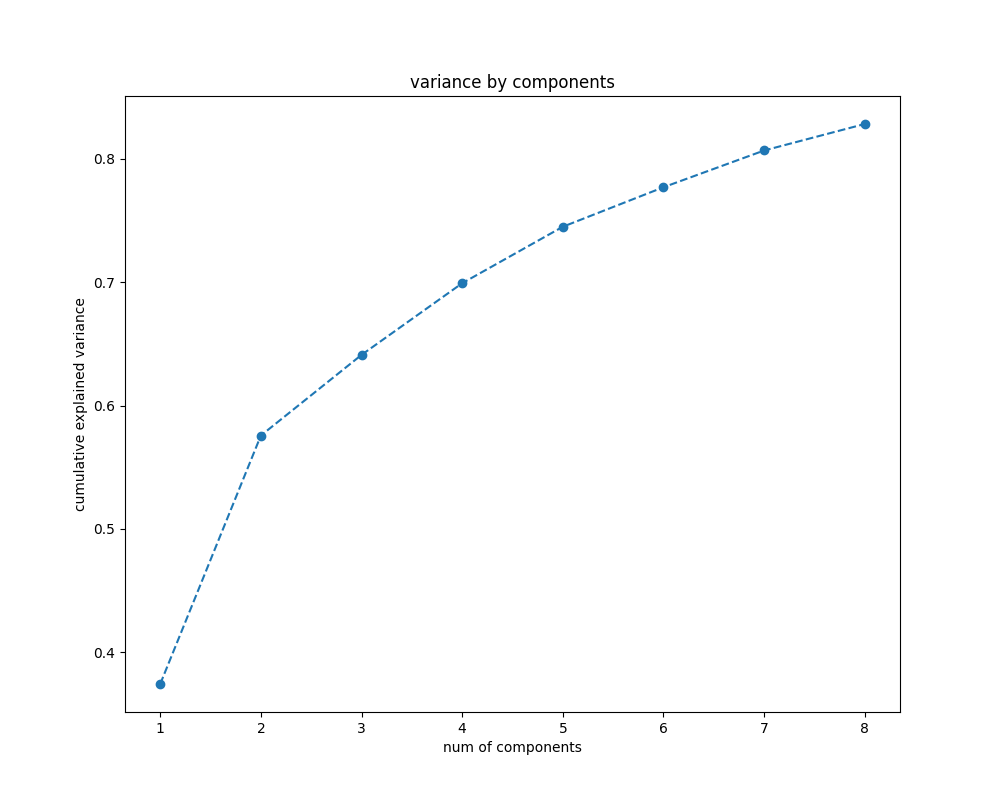

In [21]:
%matplot plt

On choisit k=4 (70% de la variance) et on applique l'ACP a nos images en deux étapes (fit puis transform)

In [22]:
t0pca_fit = time.time()
n_components = 4
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)
tfpca_fit = time.time()
print("Temps d'exécution de l'entraînement de l'ACP : {:.4f} seconds".format(tfpca_fit - t0pca_fit))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Temps d'ex?cution de l'entra?nement de l'ACP : 67.3508 seconds

In [31]:
t0pca_transform = time.time()
df_pca = pca.transform(df_scaled).select(['path','label','features','pcaFeatures'])
print('Explained Variance Ratio', pca.explainedVariance.toArray())
tfpca_transform = time.time()
print("Temps d'exécution de la transformation avec l'ACP : {:.4f} seconds".format(tfpca_transform - t0pca_transform))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Explained Variance Ratio [0.37448    0.20119965 0.06531454 0.05803088]
Temps d'ex?cution de la transformation avec l'ACP : 0.0847 seconds

In [24]:
df_pca.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features|         pcaFeatures|
+--------------------+--------------+--------------------+--------------------+
|s3://salma-p8-dat...|        Banana|[1.3663069, 0.005...|[-31.501043872936...|
|s3://salma-p8-dat...|Apple Braeburn|[0.7576222, 0.127...|[19.2549849460430...|
|s3://salma-p8-dat...|       Apricot|[0.74590665, 0.10...|[10.5011326115940...|
|s3://salma-p8-dat...|Apple Braeburn|[0.8695327, 0.006...|[17.0526221061222...|
|s3://salma-p8-dat...|Apple Braeburn|[0.6281865, 0.039...|[16.0566170524258...|
|s3://salma-p8-dat...|       Apricot|[0.46546656, 0.01...|[11.4716775252193...|
+--------------------+--------------+--------------------+--------------------+
only showing top 6 rows

<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [25]:
df_res = df_pca.withColumn("pcaFeatures", vector_to_array("pcaFeatures"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
t0_enreg = time.time()
df_res.write.mode("overwrite").parquet(PATH_Result)
tf_enreg = time.time()
print("Temps d'exécution de l'enregistrement au format parquet : {:.4f} seconds".format(tf_enreg - t0_enreg))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Temps d'ex?cution de l'enregistrement au format parquet : 29.5476 seconds

### 5- Chargement des données enregistrées et validation du résultat

In [27]:
# On lit les résultats au format parquet
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# affichage des 5 premières lignes
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                        pcaFeatures
0          s3://salma-p8-data/Test/Banana/21_100.jpg  ...  [-31.501043872936336, 1.6523266301136725, -16....
1  s3://salma-p8-data/Test/Apple Braeburn/33_100.jpg  ...  [19.25498494604301, 19.321585903246337, 0.1225...
2         s3://salma-p8-data/Test/Apricot/35_100.jpg  ...  [10.501132611594059, -20.926292982967837, 0.94...
3   s3://salma-p8-data/Test/Apple Braeburn/6_100.jpg  ...  [17.05262210612228, 15.92690982193769, -0.3247...
4   s3://salma-p8-data/Test/Apple Braeburn/3_100.jpg  ...  [16.05661705242582, 15.100968607717292, 0.0110...

[5 rows x 4 columns]

In [29]:
df.loc[0,'features']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([1.3663069 , 0.00518484, 0.        , ..., 0.04967638, 0.01305393,
       0.02820866], dtype=float32)

In [30]:
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(30, 4)